# The Secret to Getting the Second Date

### *Do you believe in love at first sight, or should I walk by again? - Anonymous* 

An analysis on the Speed Dating dataset from Kaggle: https://www.kaggle.com/annavictoria/speed-dating-experiment

 
![image](https://github.com/annaeshen/speed-dating-experiment/blob/master/speed-dating-938x625.jpg?raw=true)


## Introduction

What makes people attractive? What gets people a second date? Why isn't garlic breath a variable in this dataset?

**We're about to find out.** (Hang in there, single people!)

### About the data:
* Data was gathered from 552 participants in experimental speed dating events from 2002-2004. 
* During the events, the attendees would have a four minute "first date" with every other participant of the opposite sex. 
* At the end of their four minutes, participants were asked if they would like to see their date again. They were also asked to rate their date on six attributes: 
  * Attractiveness
  * Sincerity
  * Intelligence
  * Fun
  * Ambition
  * Shared Interests.
* The dataset also includes questionnaire data gathered from participants at different points in the process. These fields include: 
  * demographics
  * dating habits
  * self-perception across key attributes
  * beliefs on what others find valuable in a mate
  * lifestyle information

See the speed-dating-data-key.doc for data dictionary and question key.


## Table of Contents

I. [Data Cleaning and EDA](#cln)
  * [Heatmap](#hm)
  * [Interest Overlap](#io)
  * [Decisions by Gender](#dg)
  * [Unrequited Love](#url)
  * [OLS Model](#ols)


II. [Modeling](#mdl)
  * [Logistic Regression](#log)
  * [Random Forest](#rf)
  * [XGBoost](#xgb)


III. [Conclusion](#ccn)

In [1]:
# importing packages
%matplotlib inline
import pandas as pd
pd.options.display.max_rows = 1000 #handy for showing truncated results
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

In [3]:
# importing data
dating = pd.read_csv('/Users/VincentSalamand/Downloads/Speed Dating Data.csv', encoding="ISO-8859-1") # use this encoding, funky error otherwise. thanks kagglers!
dating.head(5)

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


In [4]:
# counting null values
dating.isnull().sum()

iid            0
id             1
gender         0
idg            0
condtn         0
wave           0
round          0
position       0
positin1    1846
order          0
partner        0
pid           10
match          0
int_corr     158
samerace       0
age_o        104
race_o        73
pf_o_att      89
pf_o_sin      89
pf_o_int      89
pf_o_fun      98
pf_o_amb     107
pf_o_sha     129
dec_o          0
attr_o       212
sinc_o       287
intel_o      306
fun_o        360
amb_o        722
shar_o      1076
like_o       250
prob_o       318
met_o        385
age           95
field         63
field_cd      82
undergra    3464
mn_sat      5245
tuition     4795
race          63
imprace       79
imprelig      79
from          79
zipcode     1064
income      4099
goal          79
date          97
go_out        79
career        89
career_c     138
sports        79
tvsports      79
exercise      79
dining        79
museums       79
art           79
hiking        79
gaming        79
clubbing      

## <a id="cln"> Data Cleaning and EDA</a>


From the peek at the data we had above, there are a ton of fields with NaNs. A lot of NaNs. There are 8,378 rows and a bunch of fields have thousands of NaNs and probably bad practice to use imputation to guess the values. Instead, I'll just disregard these fields with over 4000 null values from the dataset and narrow my analysis to the fields that I can use. First though, let's take a look at some totals before we throw out some fields and rows due to missing values.

Text(0, 0.5, 'Frequency')

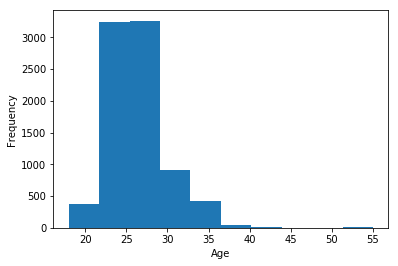

In [5]:
# age distribution of participants
age = dating[np.isfinite(dating['age'])]['age']
plt.hist(age.values)
plt.xlabel('Age')
plt.ylabel('Frequency')

So most of the participants were in their mid twenties to early thirties.

In [6]:
# out of curiosity, I want to see how many speed daters found a match!
pd.crosstab(index=dating['match'],columns="count")

col_0,count
match,
0,6998
1,1380


It looks like only about **20% of people found themselves a second date** after the speed dating session!

In [7]:
# narrowing dataset
dating_1 = dating.iloc[:, 11:28]
dating_2 = dating.iloc[:, 30:35]
dating_3 = dating.iloc[:, 39:43]
dating_4 = dating.iloc[:, 45:67]
dating_5 = dating.iloc[:, 69:74]
dating_6 = dating.iloc[:, 87:91]
dating_7 = dating.iloc[:, 97:102]
dating_8 = dating.iloc[:, 104:107]

date = pd.concat([dating.iloc[:, 0],dating.iloc[:, 2],dating_1,dating_2,dating_3,dating_4,dating_5,
                  dating_6,dating_7,dating_8], axis=1)

In [8]:
# counting null values
date.isnull().sum()

iid           0
gender        0
pid          10
match         0
int_corr    158
samerace      0
age_o       104
race_o       73
pf_o_att     89
pf_o_sin     89
pf_o_int     89
pf_o_fun     98
pf_o_amb    107
pf_o_sha    129
dec_o         0
attr_o      212
sinc_o      287
intel_o     306
fun_o       360
like_o      250
prob_o      318
met_o       385
age          95
field        63
race         63
imprace      79
imprelig     79
from         79
goal         79
date         97
go_out       79
career       89
career_c    138
sports       79
tvsports     79
exercise     79
dining       79
museums      79
art          79
hiking       79
gaming       79
clubbing     79
reading      79
tv           79
theater      79
movies       79
concerts     79
music        79
shopping     79
yoga         79
attr1_1      79
sinc1_1      79
intel1_1     79
fun1_1       89
amb1_1       99
attr3_1     105
sinc3_1     105
fun3_1      105
intel3_1    105
dec           0
attr        202
sinc        277
intel   

In [ ]:
# removing null rows now that the nulls are in the hundreds and not the thousands
date2 = date.dropna()

In [ ]:
# checking datatypes
date2.dtypes

In [ ]:
# creating an object-free dataframe for later use
date3 = date2.drop(['field', 'from', 'career'], axis=1)

In [ ]:
# heatmap
plt.subplots(figsize=(20,15))
ax = plt.axes()
ax.set_title("Correlation Heatmap")
corr = date3.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In looking at the <a id="hm">heatmap</a> above, there are some interesting observations.

For example, men (gender = 1) seem to have a preference for attractive partners (attr1_1) while women (gender = 0) seem to have a preference for ambitious partners (amb1_1)!

In other news, women like shopping and yoga and men like gaming, so at least we know this heatmap is working. Let's look into the <a id="hm">interests</a> some more!

In [ ]:
# just for fun, looking at interest overlap
sns.set(style="ticks", color_codes=True)
date_int = pd.concat([date3.iloc[:, 1],date3.iloc[:, 30:32]],axis = 1)
g = sns.pairplot(date_int, hue="gender")

In [ ]:
# just for fun, looking at interest overlap
sns.set(style="ticks", color_codes=True)
date_int = pd.concat([date3.iloc[:, 1],date3.iloc[:, 33:36]],axis = 1)
g = sns.pairplot(date_int, hue="gender")

In [ ]:
# just for fun, looking at interest overlap
sns.set(style="ticks", color_codes=True)
date_int2 = pd.concat([date3.iloc[:, 1],date3.iloc[:, 41:44]],axis = 1)
g = sns.pairplot(date_int2, hue="gender")

In [ ]:
# just for fun, looking at interest overlap
sns.set(style="ticks", color_codes=True)
date_int3 = pd.concat([date3.iloc[:, 1],date3.iloc[:, 45:47]],axis = 1)
g = sns.pairplot(date_int3, hue="gender")

Just for fun, I wanted to see how interests differed by gender. The histograms above show that **if you want to suggest a date that both genders are likely to enjoy, choose movies or dining!**

However, referring back to the heatmap none of the interests really correlated with match, so that gives me the go-ahead to remove interests from my match prediction model!

It also looks like match (the variable we are interested in) is mostly correlated to the decisions of the partners, and the partner's attributes (how well they rated the partner's attractiveness, sincerity, intelligence, fun, ambition, and how much they liked them).

Interestingly, match was not correlated to age or race, or even how similar the participant and partner's interests are (int_corr)! Love does not discriminate according to the data!

In [ ]:
# removing interests
date4 = date3.drop(['sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 
                    'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 
                   'shopping', 'yoga'], axis=1)

Going along investigating further <a id="gd">gender differences</a>, I wonder... how many of each gender are there and does that affect the other person's decision? That is, do women receive more positive final decisions from the other person (dec_o) than men do?

In [ ]:
# looking at dec_o by gender
sns.set(style="ticks", color_codes=True)
g = sns.FacetGrid(date4, col="gender")
g = g.map(plt.hist, "dec_o")
plt.ticklabel_format(useOffset=False, style='plain')

In [ ]:
# chi-square test
gender_crosstab = pd.crosstab(index=date4.gender, columns=date4.dec_o)
gender_table = sm.stats.Table(gender_crosstab)
gender_rslt = gender_table.test_nominal_association()
gender_rslt.pvalue

It looks like women received about 1750 'no' and about 1600 'yes' for the decision question "Would you like to see him or her again?". Men received about 2050 'no' and about 1300 'yes'. In other words, **men are more likely to be rejected by women than women are to be rejected by men** (wahwah). This is a statistically significant difference as confirmed by the above chi-squared test p-value. Poor guys!

Now, I wonder, how many interactions were <a id="url">unrequited love</a>? That is, getting the count of rows where dec_o = 1 AND dec = 0 OR a dec = 1 AND dec_o = 0?

In [ ]:
# unrequited love count
no_love_count = len(date4[(date4['dec_o']==0) & (date4['dec']==1)]) 
+ len(date4[(date4['dec_o']==1) & (date4['dec']==0)])
perc_broken_heart = no_love_count / len(date4.index)
perc_broken_heart*100

So it seems **26% of participants unfortunately had their heart broken**. More than the percentage of people who got a second date! 

On an unrelated note, I wonder if the incidence of unrequited love differs by the attractiveness of the partner.

In [ ]:
# encoding unrequited love as a new column
date4['url']=np.where(((date4['dec_o']==0) & (date4['dec']==1))|((date4['dec']==0) & (date4['dec_o']==1)),1,0)

In [ ]:
# looking at url by attractiveness
plt.figure(figsize=(7,9))
sns.boxplot(x='url', y='attr', data=date4, palette='cool')
plt.title('Broken Hearts by Attractiveness of Partner', fontsize=20)
plt.xlabel('Broken Heart', fontsize=16)

In [ ]:
# chi-square test
bh_crosstab = pd.crosstab(index=date4.attr, columns=date4.url)
bh_table = sm.stats.Table(bh_crosstab)
bh_rslt = bh_table.test_nominal_association()
bh_rslt.pvalue

Looks like the difference in attractiveness was not statistically significant. So the good news is, the likelihood of getting rejected is not dependent on your attractiveness!

In [ ]:
date5 = pd.concat([date4['attr3_1'],date4['sinc3_1'],date4['intel3_1'],date4['fun3_1'],date4['attr_o'],
                   date4['sinc_o'],date4['intel_o'],date4['fun_o'],date4['like'],date4['like_o'], 
                   date4['int_corr'],date4['url']],axis=1)
plt.subplots(figsize=(15,10))
ax = plt.axes()
ax.set_title("Correlation Heatmap")
corr = date5.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

It looks like regardless of your attractiveness, or any other trait for that matter, you are just as likely to experience heartbreak!

It also looks like typically, your own opinion of how attractive you are (attr3_1) is only weakly correlated with how attractive your date finds you (attr_o)! And in fact, there is nearly no correlation between how smart or sincere you think you are versus how smart and sincere your date thinks of you! Perhaps these are tough qualities to get across in a 4 minute date!

So that brings up the question, between attractiveness, sincerity, intelligence, fun, ambition, and liking, what was the most influential in the final decision (dec)? I'll run a <a id="ols">linear regression model</a>.

In [ ]:
# OLS model with coefficients
X_ols = date4[['attr','sinc','intel','fun','like','int_corr']]
y_ols = date4.dec
traits = sm.OLS(y_ols, X_ols)
results_traits = traits.fit()
results_traits.summary()

It turns out that being intelligent or sincere or having similar interests actually slightly hurts your chances at securing that second date! Don't panic though, this is just from 4 minutes of meeting each other! We might take this as advice to focus on breaking the ice and being more fun and likeable in the first date!

Now let's run an OLS but with both respondents' ratings instead of just one, and this time on match instead of decision (dec).

In [ ]:
# OLS model with coefficients
X_ols = date4[['dec','dec_o','attr','attr_o','fun','fun_o','like','like_o','int_corr']]
y_ols = date4.match
traits = sm.OLS(y_ols, X_ols)
results_traits = traits.fit()
results_traits.summary()

**From the coefficients, it looks like all that really matters is the decision of both participants, and perhaps whether or not they liked one another.**

## <a id="mdl"> Modeling - Classification </a>

In [ ]:
# preparing the data
X=date4[['like','dec']]
y=date4['match']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [ ]:
# logistic regression classification model
model = LogisticRegression(C=1, random_state=0)
lrc = model.fit(X_train, y_train)
predict_train_lrc = lrc.predict(X_train)
predict_test_lrc = lrc.predict(X_test)
print('Training Accuracy:', metrics.accuracy_score(y_train, predict_train_lrc))
print('Validation Accuracy:', metrics.accuracy_score(y_test, predict_test_lrc))

Without knowing what the partner's decision is (dec_o), it turns out that given how much the respondent likes the partner and what the respondent's decision is, we have about an 82.5% accuracy in predicting a match on both the training and the validation using <a id="rf">logistic regression</a>. This makes sense given that we know only 26% of people were heartbroken -- if you like someone, odds are they will like you back!

Let's try some other models to see if we can get closer to predicting a match.

In [ ]:
# random forest model
model = RandomForestClassifier()
rf_model = model.fit(X_train, y_train)
predict_train_rf = rf_model.predict(X_train)
predict_test_rf = rf_model.predict(X_test)
print('Training Accuracy:', metrics.accuracy_score(y_train, predict_train_rf))
print('Validation Accuracy:', metrics.accuracy_score(y_test, predict_test_rf))

<a id="rf">Random forest</a> gave us a slightly more accurate model at 82.9% accuracy in train and 82.8% in test.

In [ ]:
# xgboost model
model = GradientBoostingClassifier()
xgb_model = model.fit(X_train, y_train)
predict_train_xgb = xgb_model.predict(X_train)
predict_test_xgb = xgb_model.predict(X_test)
print('Training Accuracy:', metrics.accuracy_score(y_train, predict_train_xgb))
print('Validation Accuracy:', metrics.accuracy_score(y_test, predict_test_xgb))

<a id="xgb">XGBoost</a> was ever so slightly less accurate than Random Forest in the validation set. Looks like Random Forest is my champion model.

## <a id="ccn"> Conclusion </a>

Although this was slightly disappointing, it looks like there still is no real answers to the secret of love. It's not interests or hobbies, it's not attractiveness or intelligence or other traits. Really it's just how much someone likes you. Who would have thought?

On the other hand, we did learn a thing or two. To summarize:
 * Take your date out to the cliche dinner and a movie because both genders are likely to enjoy it
 * Dating is tougher for men (perhaps women can be more selective?)
 * More participants experienced unrequited love than those that found love -- so don't feel too bad
 * People get their heartbroken regardless of their personal traits like attractiveness, so if you strike out, it's not you that is the problem
 * Your impression of yourself is often wrong
 * There is no one trait that makes you likeable
 * Being likeable is important for securing that second date!
